https://stepik.org/lesson/501479/step/1?unit=493164  
https://drive.google.com/drive/folders/15UoRIwvCOZ-6c624m5NTDfbFizOs-C0N  

In [733]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [734]:
num_cols = [
    'ClientPeriod',
    'MonthlySpending',
    'TotalSpent'
]

cat_cols = [
    'Sex',
    'IsSeniorCitizen',
    'HasPartner',
    'HasChild',
    'HasPhoneService',
    'HasMultiplePhoneNumbers',
    'HasInternetService',
    'HasOnlineSecurityService',
    'HasOnlineBackup',
    'HasDeviceProtection',
    'HasTechSupportAccess',
    'HasOnlineTV',
    'HasMovieSubscription',
    'HasContractPhone',
    'IsBillingPaperless',
    'PaymentMethod'
]

feature_cols = num_cols + cat_cols
target_col = 'Churn'

In [735]:
data = pd.read_csv('./train.csv')

In [736]:
pd.DataFrame({'dtype': data[num_cols].dtypes, 'na': data[num_cols].isna().sum()})

,dtype,na
ClientPeriod,int64,0
MonthlySpending,float64,0
TotalSpent,object,0


In [737]:
data['TotalSpent'] = pd.to_numeric(data['TotalSpent'], errors='coerce')
pd.DataFrame({'dtype': data[num_cols].dtypes, 'na': data[num_cols].isna().sum()})

,dtype,na
ClientPeriod,int64,0
MonthlySpending,float64,0
TotalSpent,float64,9


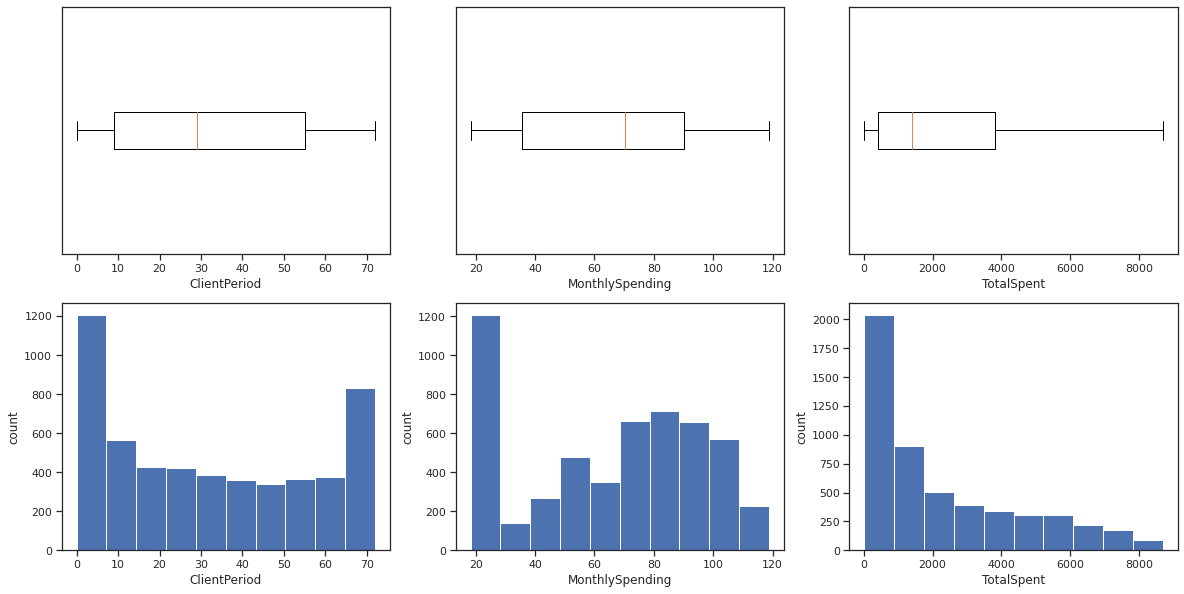

In [738]:
fig, axes = plt.subplots(2, len(num_cols), figsize=(20,10))

for i,c in enumerate(num_cols): 
    ax = axes.flat[i]
    ax.boxplot(data[c].dropna(), vert=False)
    ax.set_xlabel(c)
    ax.set_yticks([])

for i,c in enumerate(num_cols):
    ax = axes.flat[len(num_cols) + i]
    ax.hist(data[c].dropna())
    ax.set_xlabel(c)
    ax.set_ylabel('count')

In [739]:
# no outliers -> mean
data[num_cols] = data[num_cols].fillna(data[num_cols].mean())
pd.DataFrame({'dtype': data[num_cols].dtypes, 'na': data[num_cols].isna().sum()})

,dtype,na
ClientPeriod,int64,0
MonthlySpending,float64,0
TotalSpent,float64,0


In [740]:
data['Churn'].isna().sum()

0

In [741]:
# imbalanced or not ?
cls0, cls1 = (data['Churn'] == 0).sum(), (data['Churn'] == 1).sum()
print(f'class 0: {cls0}, class 1: {cls1}, class ratio: {cls0 / cls1:.2f}')

class 0: 3898, class 1: 1384, class ratio: 2.82


In [742]:
pd.DataFrame({'dtype': data[cat_cols].dtypes, 'na': data[cat_cols].isna().sum()})

,dtype,na
Sex,object,0
IsSeniorCitizen,int64,0
HasPartner,object,0
HasChild,object,0
HasPhoneService,object,0
HasMultiplePhoneNumbers,object,0
HasInternetService,object,0
HasOnlineSecurityService,object,0
HasOnlineBackup,object,0
HasDeviceProtection,object,0


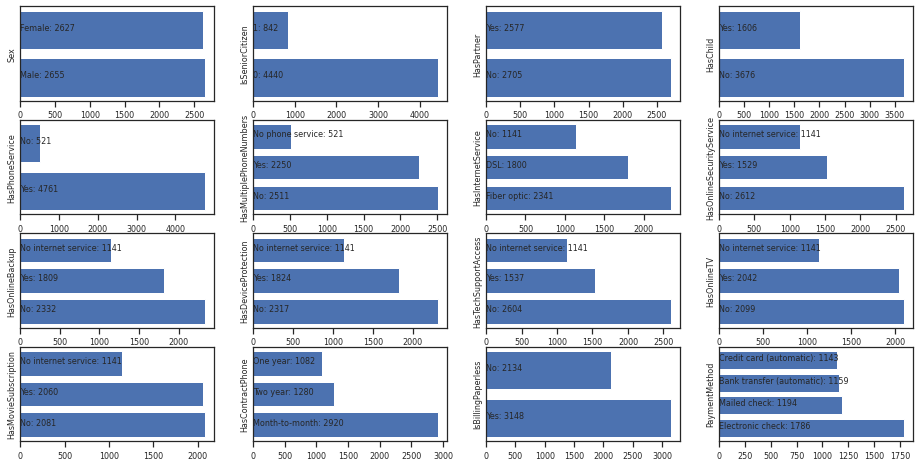

In [743]:
fig, axes = plt.subplots(4, 4, figsize=(16,8))
for c, ax in zip(cat_cols, axes.flat):
    cnt = data[c].value_counts()
    ax.barh(cnt.index, cnt.values) # color='lightskyblue'
    ax.set_ylabel(c, fontsize=8)
    ax.set_yticks([])
    ax.tick_params(axis="x", labelsize=8)
    for i, k, v in zip(range(len(cnt)), cnt.index, cnt.values):
        ax.text(0, i, f'{k}: {v}', fontsize=8) # color='royalblue'

In [1171]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

In [1067]:
num_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())])

cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_cols),
        ('cat', cat_transformer, cat_cols)])

classifier = LogisticRegression(C=0.1, solver='liblinear')
model = Pipeline(steps=[('pre', preprocessor), ('clf', classifier)])

In [1072]:
grid = {'clf__C':[1000, 100, 10, 1, 0.1], 'clf__penalty':['l1','l2']}
cv = GridSearchCV(model, grid, scoring='roc_auc')
cv.fit(data[feature_cols], data[target_col])
cv.best_estimator_

Pipeline(steps=[('pre',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['ClientPeriod',
                                                   'MonthlySpending',
                                                   'TotalSpent']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                             

In [1074]:
cross_val_score(cv.best_estimator_, data[feature_cols], data[target_col], scoring='roc_auc', cv=3).mean()

0.843014766488388

In [1127]:
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

In [1128]:
X_train, X_valid, y_train, y_valid = train_test_split(data[feature_cols], data[target_col], test_size=0.2, random_state=42)

In [1129]:
catboost = CatBoostClassifier()
catboost.set_params(cat_features=cat_cols, silent=True)
catboost.fit(X_train, y_train)

In [1130]:
roc_auc_score(y_train, catboost.predict_proba(X_train)[:,1])

0.8953653945050085

In [1131]:
roc_auc_score(y_valid, catboost.predict_proba(X_valid)[:,1])

0.8267101338184908

In [1132]:
cross_val_score(catboost, data[feature_cols], data[target_col], scoring='roc_auc').mean()

0.8424507486134345

In [ ]:
grid = {'learning_rate':[0.05,0.1,0.2,0.5,1], 'num_trees':[10,50,100,200]}
catboost = CatBoostClassifier()
catboost.set_params(cat_features=cat_cols, silent=True)
result = catboost.grid_search(grid, X_train, y_train, cv=3)

In [919]:
result['params']

{'iterations': 100, 'learning_rate': 0.1}

In [920]:
roc_auc_score(y_train, catboost.predict_proba(X_train)[:,1])

0.8675405422171872

In [921]:
roc_auc_score(y_valid, catboost.predict_proba(X_valid)[:,1])

0.8267678540094754

In [922]:
cross_val_score(catboost, data[feature_cols], data[target_col], scoring='roc_auc').mean()

0.8467319026329996

In [923]:
grid = {'learning_rate':[0.05,0.1,0.2,0.5,1], 'num_trees':[10,50,100,200]}
catboost = CatBoostClassifier().set_params(cat_features=cat_cols, silent=True)
cv = GridSearchCV(catboost, grid, scoring='roc_auc')
cv.fit(data[feature_cols], data[target_col]);

In [924]:
cv.best_estimator_.get_params()['learning_rate']

0.1

In [925]:
cv.best_estimator_.get_params()['num_trees']

100

In [926]:
roc_auc_score(y_train, cv.best_estimator_.predict_proba(X_train)[:,1])

0.8688280775762158

In [927]:
roc_auc_score(y_valid, cv.best_estimator_.predict_proba(X_valid)[:,1])

0.8455661658093294

In [928]:
cross_val_score(cv.best_estimator_, data[feature_cols], data[target_col], scoring='roc_auc').mean()

0.8467319026329996

In [1079]:
num_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())])

cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_cols),
        ('cat', cat_transformer, cat_cols)])

classifier = LogisticRegression(C=100, penalty='l1', solver='liblinear')
model = Pipeline(steps=[('pre', preprocessor), ('clf', classifier)])

print(cross_val_score(model, data[feature_cols], data[target_col], scoring='roc_auc', cv=3).mean())
model.fit(data[feature_cols], data[target_col])

X_test = pd.read_csv('./test.csv')
X_test['TotalSpent'] = pd.to_numeric(X_test['TotalSpent'], errors='coerce')
X_test[num_cols] = X_test[num_cols].fillna(X_test[num_cols].mean())

submission = pd.read_csv('./submission.csv')
submission['Churn'] = model.predict_proba(X_test)[:,1]
submission.to_csv('./my_submission.csv', index=False)

0.8429986586538014


In [1081]:
model = CatBoostClassifier(learning_rate=0.1, num_trees=100)
model.set_params(cat_features=cat_cols, silent=True)

print(cross_val_score(model, data[feature_cols], data[target_col], scoring='roc_auc', cv=3).mean())
model.fit(data[feature_cols], data[target_col])

X_test = pd.read_csv('./test.csv')
X_test['TotalSpent'] = pd.to_numeric(X_test['TotalSpent'], errors='coerce')
X_test[num_cols] = X_test[num_cols].fillna(X_test[num_cols].mean())

submission = pd.read_csv('./submission.csv')
submission['Churn'] = model.predict_proba(X_test)[:,1]
submission.to_csv('./my_submission.csv', index=False)

0.8459648764570789


In [1135]:
num_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean'))])

cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_cols),
        ('cat', cat_transformer, cat_cols)])

classifier = CatBoostClassifier(learning_rate=0.1, num_trees=100)
model = Pipeline(steps=[('pre', preprocessor), ('clf', classifier)])
# model.fit(data[feature_cols], data[target_col])
print(cross_val_score(model, data[feature_cols], data[target_col], scoring='roc_auc').mean())

# X_test = pd.read_csv('./test.csv')
# X_test['TotalSpent'] = pd.to_numeric(X_test['TotalSpent'], errors='coerce')
# X_test[num_cols] = X_test[num_cols].fillna(X_test[num_cols].mean())

# submission = pd.read_csv('./submission.csv')
# submission['Churn'] = model.predict_proba(X_test)[:,1]
# submission.to_csv('./my_submission.csv', index=False)

0:	learn: 0.6248354	total: 2.38ms	remaining: 236ms
1:	learn: 0.5786481	total: 4.73ms	remaining: 232ms
2:	learn: 0.5408673	total: 8.11ms	remaining: 262ms
3:	learn: 0.5128780	total: 10.6ms	remaining: 255ms
4:	learn: 0.4933220	total: 13.1ms	remaining: 250ms
5:	learn: 0.4765489	total: 15.7ms	remaining: 246ms
6:	learn: 0.4621271	total: 18.2ms	remaining: 242ms
7:	learn: 0.4528206	total: 20.6ms	remaining: 237ms
8:	learn: 0.4440373	total: 23.1ms	remaining: 233ms
9:	learn: 0.4369304	total: 25.5ms	remaining: 230ms
10:	learn: 0.4294961	total: 28.1ms	remaining: 227ms
11:	learn: 0.4251287	total: 30.5ms	remaining: 224ms
12:	learn: 0.4208695	total: 33.1ms	remaining: 221ms
13:	learn: 0.4160487	total: 35.6ms	remaining: 218ms
14:	learn: 0.4127383	total: 38ms	remaining: 215ms
15:	learn: 0.4094722	total: 40.4ms	remaining: 212ms
16:	learn: 0.4074512	total: 42.9ms	remaining: 210ms
17:	learn: 0.4049399	total: 45.4ms	remaining: 207ms
18:	learn: 0.4031955	total: 47.8ms	remaining: 204ms
19:	learn: 0.4007628	tot

85:	learn: 0.3365308	total: 245ms	remaining: 39.9ms
86:	learn: 0.3354001	total: 249ms	remaining: 37.2ms
87:	learn: 0.3345128	total: 252ms	remaining: 34.4ms
88:	learn: 0.3333236	total: 256ms	remaining: 31.7ms
89:	learn: 0.3328174	total: 263ms	remaining: 29.2ms
90:	learn: 0.3323207	total: 265ms	remaining: 26.2ms
91:	learn: 0.3315063	total: 268ms	remaining: 23.3ms
92:	learn: 0.3309207	total: 270ms	remaining: 20.4ms
93:	learn: 0.3300319	total: 273ms	remaining: 17.4ms
94:	learn: 0.3296333	total: 276ms	remaining: 14.5ms
95:	learn: 0.3291054	total: 278ms	remaining: 11.6ms
96:	learn: 0.3286688	total: 281ms	remaining: 8.68ms
97:	learn: 0.3281344	total: 283ms	remaining: 5.78ms
98:	learn: 0.3277121	total: 286ms	remaining: 2.88ms
99:	learn: 0.3270262	total: 288ms	remaining: 0us
0:	learn: 0.6238643	total: 2.51ms	remaining: 248ms
1:	learn: 0.5806511	total: 5.1ms	remaining: 250ms
2:	learn: 0.5384747	total: 7.54ms	remaining: 244ms
3:	learn: 0.5109528	total: 9.94ms	remaining: 238ms
4:	learn: 0.4913459	

68:	learn: 0.3537818	total: 198ms	remaining: 89.2ms
69:	learn: 0.3528648	total: 203ms	remaining: 87ms
70:	learn: 0.3525513	total: 207ms	remaining: 84.4ms
71:	learn: 0.3519327	total: 212ms	remaining: 82.3ms
72:	learn: 0.3514687	total: 216ms	remaining: 79.8ms
73:	learn: 0.3511960	total: 220ms	remaining: 77.2ms
74:	learn: 0.3504230	total: 222ms	remaining: 74.1ms
75:	learn: 0.3501666	total: 225ms	remaining: 71.1ms
76:	learn: 0.3490747	total: 228ms	remaining: 68.1ms
77:	learn: 0.3487556	total: 232ms	remaining: 65.4ms
78:	learn: 0.3478489	total: 235ms	remaining: 62.5ms
79:	learn: 0.3471870	total: 238ms	remaining: 59.4ms
80:	learn: 0.3466057	total: 241ms	remaining: 56.4ms
81:	learn: 0.3459495	total: 243ms	remaining: 53.4ms
82:	learn: 0.3452101	total: 246ms	remaining: 50.3ms
83:	learn: 0.3440022	total: 250ms	remaining: 47.7ms
84:	learn: 0.3426411	total: 253ms	remaining: 44.7ms
85:	learn: 0.3419773	total: 256ms	remaining: 41.7ms
86:	learn: 0.3411432	total: 259ms	remaining: 38.6ms
87:	learn: 0.3

In [1136]:
cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(transformers=[('cat', cat_transformer, cat_cols)])
classifier = RandomForestClassifier(n_estimators=200, max_depth=3, criterion="gini")
model = Pipeline(steps=[('pre', preprocessor), ('clf', classifier)])

print(cross_val_score(model, data[feature_cols], data[target_col], scoring='roc_auc').mean())
model.fit(data[feature_cols], data[target_col])

X_test = pd.read_csv('./test.csv')
X_test['TotalSpent'] = pd.to_numeric(X_test['TotalSpent'], errors='coerce')
X_test[num_cols] = X_test[num_cols].fillna(X_test[num_cols].mean())

submission = pd.read_csv('./submission.csv')
submission['Churn'] = model.predict_proba(X_test)[:,1]
submission.to_csv('./my_submission.csv', index=False)

0.8237805496405558


In [1193]:
from sklearn.neighbors import KNeighborsClassifier

num_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())])

cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_cols),
        ('cat', cat_transformer, cat_cols)])

classifier = KNeighborsClassifier(n_neighbors=60, metric='euclidean')
model = Pipeline(steps=[('pre', preprocessor), ('clf', classifier)])

print(cross_val_score(model, data[feature_cols], data[target_col], scoring='roc_auc', cv=3).mean())
model.fit(data[feature_cols], data[target_col])

X_test = pd.read_csv('./test.csv')
X_test['TotalSpent'] = pd.to_numeric(X_test['TotalSpent'], errors='coerce')
X_test[num_cols] = X_test[num_cols].fillna(X_test[num_cols].mean())

submission = pd.read_csv('./submission.csv')
submission['Churn'] = model.predict_proba(X_test)[:,1]
submission.to_csv('./my_submission.csv', index=False)

0.8343514776785906


In [335]:
# data[num_cols].info()
# data[num_cols].isna().sum() # isnull().sum()
# data[num_cols].dtypes
# (data['TotalSpent'] == ' ').sum(), data['TotalSpent'].isna().sum()
# (data['TotalSpent'].str.extract(r'(\d+.\d+)').isna()).sum()
# data['TotalSpent'] = data['TotalSpent'].replace(' ', np.nan).astype(float)
# data['TotalSpent'] = data['TotalSpent'].str.extract(r'(\d+.\d+)').astype('float')
# fig, axes = plt.subplots(1, len(num_cols), figsize=(16,6))
# for i,c in enumerate(num_cols): axes[i].boxplot(data[c].dropna())
# fig, axes = plt.subplots(1, len(num_cols), figsize=(16,3))
# for i,c in enumerate(num_cols): axes[i].hist(data[c].dropna())
# df[['dtype']].style.apply(lambda x: ['color: red' if v == object else '' for v in x])
# df[['na']].style.apply(lambda x: ['color: red' if v > 0 else '' for v in x])
# data['IsSeniorCitizen'].unique()

In [611]:
# sns.set(style='ticks')
# f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})
# sns.boxplot(data=data, x='ClientPeriod', ax=ax_box)
# sns.histplot(data=data, x='ClientPeriod', ax=ax_hist)
# ax_box.set(yticks=[])
# sns.despine(ax=ax_hist)
# sns.despine(ax=ax_box, left=True)

In [612]:
# plt.figure(figsize=(10,2))
# plt.yticks(data['Churn'].unique())
# plt.hist(data['Churn'], orientation='horizontal');